# Ultimate Fandoms

## 1 Motivation


* What is your dataset?
* Why did you choose this/these particular dataset(s)?
* What was your goal for the end user's experience?

In [1]:
# Imports for the whole Analysis

from urllib.request import urlopen
import json
import re
from urllib.parse import quote
import pandas as pd
from pandas.io.json import json_normalize
import collections
import itertools
import networkx as nx
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2
import numpy as np
import datetime
import ast # string to dirc
# conda install -c phlya adjusttext 
#from adjustText import adjust_text

## 2 Basic stats


* Write about your choices in data cleaning and preprocessing.
* Write a short section that discusses the dataset stats (here you can recycle the work you did for Project Assignment A)

In [2]:
# Get wikis/dataset from csv
fullDataSet = pd.read_csv("data/sortedWikiData.csv", sep='\t')

# Drop old index column named "Unnamed: 0"
fullDataSet = fullDataSet.drop(['Unnamed: 0'], axis=1)
fullDataSet.head()

,creation_date,desc,domain,flags,founding_user_id,headline,hub,id,image,lang,language,name,original_dimensions,stats,title,topUsers,topic,url,wam_score,wordmark
0,2006-01-10 15:06:36,NaN,broadcasting.wikia.com,[],12423.0,NaN,TV,942,NaN,en,en,Radio-TV Broadcast History,NaN,"{'edits': 24380, 'articles': 4362, 'pages': 56...",Radio-TV Broadcast History,"[4106832, 27024879, 36887098, 37504326, 268032...",Education,http://broadcasting.wikia.com,2.4801,NaN
1,2006-03-16 06:06:01,NaN,realitytv.wikia.com,[],19261.0,NaN,TV,1245,NaN,en,en,Reality TV,NaN,"{'edits': 2812, 'articles': 59, 'pages': 601, ...",Reality TV,"[24878039, 1094479]",TV,http://realitytv.wikia.com,0.0000,NaN
2,2006-05-27 12:27:18,NaN,zh.tv.wikia.com,[],23838.0,NaN,TV,1592,NaN,zh-tw,zh-tw,中文電視大典,NaN,"{'edits': 18338, 'articles': 977, 'pages': 403...",中文電視大典,"[36879666, 36808293, 36843235, 4784321, 581119...",TV,http://zh.tv.wikia.com,4.7445,NaN
3,2006-07-05 12:34:17,NaN,tvchannels.wikia.com,[],0.0,NaN,TV,1776,NaN,en,en,Telepedia,NaN,"{'edits': 2097, 'articles': 92, 'pages': 210, ...",Telepedia,"[30349598, 35485334, 36156286]",TV,http://tvchannels.wikia.com,0.0000,NaN
4,2006-03-16 13:42:45,NaN,mtv.wikia.com,[],0.0,NaN,TV,2155,NaN,en,en,MTV Wiki,NaN,"{'edits': 2139, 'articles': 56, 'pages': 227, ...",MTV Wiki,"[34715148, 28602916, 957747]",Music,http://mtv.wikia.com,0.0000,NaN


In [3]:
# Methode that remove inactive wikis and duplicates
def findActiveWikis(dataSet):
    activeDataSet = pd.DataFrame()
    
    # Remove duplicates
    dataSet = dataSet.drop_duplicates()
    
    # Find stats in dataset
    for wiki in dataSet.T.items():
        wiki = wiki[1]
        stats = wiki['stats']
        
        # Only add wiki to list when at in contains at least 1 active user
        sDirc = ast.literal_eval(stats)
        if int(sDirc['activeUsers'])>1:
            activeDataSet = activeDataSet.append(wiki) 
    
    # Create new index
    activeDataSet = activeDataSet.reset_index(drop=True)
    return activeDataSet

In [4]:
### Filter Wiki Data ###
activeDataSet = findActiveWikis(fullDataSet)

print("%s Wikis before filter, and %s Wikis efter filter.\n%s has been removed" % 
      (len(fullDataSet),len(activeDataSet),len(fullDataSet)-len(activeDataSet)))

activeDataSet.head()

# Data memory usage
print(sum(activeDataSet.memory_usage(index=False, deep=True))/1000)

35039 Wikis before filter, and 5585 Wikis efter filter.
29454 has been removed
7978.467


In [5]:
fullDataSet.loc[fullDataSet['name'] =='The Purge Wiki'].values

array([['2013-04-07 11:42:45', nan, 'thepurge.wikia.com', '[]',
        7915494.0, nan, 'Movies', 723826, nan, 'en', 'en',
        'The Purge Wiki', nan,
        "{'edits': 477, 'articles': 26, 'pages': 362, 'users': 15934463, 'activeUsers': 4, 'images': 56, 'videos': 1, 'admins': 2}",
        'The Purge Wiki',
        '[25464118, 3061027, 32234559, 31114473, 5956954, 26635429, 24851773, 27481640]',
        'Movies', 'http://thepurge.wikia.com', 0.0,
        'https://vignette.wikia.nocookie.net/thepurge/images/8/89/Wiki-wordmark.png/revision/latest?cb=20180625172856'],
       ['2014-06-24 01:49:34', nan, 'purge.wikia.com', '[]', 25070794.0,
        nan, 'Movies', 996597, nan, 'en', 'en', 'The Purge Wiki', nan,
        "{'edits': 1650, 'articles': 32, 'pages': 882, 'users': 15995994, 'activeUsers': 3, 'images': 648, 'videos': 0, 'admins': 3}",
        'The Purge Wiki',
        '[14072752, 3440938, 25416509, 32234559, 171752, 34943820, 1951921, 34337273]',
        'Movies', 'http://purge

The Wikis will be the nodes of our network, however we need to connect these nodes. We will do this by finding multiple user profiles and connecting all the wikis which the individual user is active in. The users will thereby create small cliques, that in the end will give a knowledge over which wikis are the most connected.

In [6]:
# Methode that tage a string representing a list and makes it into a list
def makeStringToList(string):
    if string == "[]":
        return []
    string = string.replace("['","")
    string = string.replace("']","")
    
    # Some Wikis have '_' instead og ' ', which needs to be replaced. 
    string = string.replace("_"," ")
    listCreated = string.split("', '")
    return listCreated

In [7]:
### Get Users from user-wikis ###
users = {}

# Open file
filename = "data/users/user-wikis.txt"
f = open(filename, "r")

# Read content and create dircetory of wikis the users are active in
for line in f.read().splitlines():
    user = line.split(': ')
    if len(user) == 2:
        if user[0] not in users:
            users[user[0]] = []
            
        # Remove duplicates and add to the list
        users[user[0]] = list(set(users[user[0]]+makeStringToList(user[1])))

print("%s users have been found in user-wikis.txt" % len(users))

22241 users have been found in user-wikis.txt


### Creating the network

The network is going to be a undirected graph containing multilple cliques. The nodes will be the wikis with the attributes: Hub, allUsers and activeUsers according to the dataset, and usersOccurances, which is the number of times the wiki is mentioned in our user data: user-wikis.txt.

In [8]:
# Make graph
G = nx.Graph()

In [9]:
# Add nodes
duplicate_name_node_count = 0
for wiki in activeDataSet.T.items():
    wiki = wiki[1]
    name = wiki['name']
    
    # If wiki is NaN do not create node
    if str(name) == "nan":
        print("Do not add wiki if it is NaN (%s)" % name)
        continue
    
    # Make name fit wiki name in user-wikis.txt
    name = name.replace("_"," ")

    # Find hub value
    hub = wiki['hub']
    
    # Find user values
    stats = ast.literal_eval(wiki['stats'])
    allUsers = stats['users']
    activeUsersStats = stats['activeUsers']
    
    # Count occurances in user-wikis.txt
    usersOccurances = 0
    for values in users.values():
        for value in values:
            if value == name:
                usersOccurances+=1
    
    # Check if Wiki Name have a node
    if name not in G.nodes():
        # Create new node
        G.add_node(name, 
                   hub=hub, 
                   allUsers=allUsers, 
                   activeUsers=activeUsersStats, 
                   usersOccurances=usersOccurances)
    else:
        # Update excisting node by merging new values
        duplicate_name_node_count+=1
        if hub not in G.node[name]['hub']:
            G.node[name]['hub'] = G.node[name]['hub']+", "+hub
        
        # Find average of the user numbers 
        # taking into account if one user is member of both Wikis
        if G.node[name]['allUsers'] != allUsers:
            G.node[name]['allUsers'] = str(int((int(G.node[name]['allUsers'])+int(allUsers))/2))  
                                                                                                                                
        if G.node[name]['activeUsers'] != activeUsersStats:
            G.node[name]['activeUsers'] = str(int((int(G.node[name]['activeUsers'])+int(activeUsersStats))/2))  
        
        # If different number of occurances (should not happend), then return the sum
        if G.node[name]['usersOccurances'] != usersOccurances:
            G.node[name]['usersOccurances'] = str(int(G.node[name]['usersOccurances'])+int(usersOccurances)) 

print("Number of nodes added to the graph: %s,\nNumber of nodes merged: %s,\nNumber of wikis: %s" % 
      (duplicate_name_node_count, len(G.nodes()), len(activeDataSet)))

Do not add wiki if it is NaN (nan)
Number of nodes added to the graph: 346,
Number of nodes merged: 5238,
Number of wikis: 5585


In [10]:
# Methodes that create edges between all wikis which share users (cliques)
def createEdges(G,userWikis):
    length = len(userWikis)
    
    # Check if it is the last wiki in the list
    if length<=1:
        return G
    
    # Resursive call
    elif length>1:
        wiki = userWikis.pop()
        # Check wiki exsist in dataset
        if wiki in G.nodes():
            wikisNotInDataSet = []

            # Create edges
            for w in userWikis:
                if w in G.nodes():
                    if G.has_edge(wiki, w):
                        G[wiki][w]['weight']+=1
                    else:
                        G.add_edge(wiki,w,weight=1)
                else:
                    wikisNotInDataSet.append(w)
            if len(wikisNotInDataSet) > 0:
                length = len(userWikis)
                userWikis = list(set(userWikis) - set(wikisNotInDataSet))
        return createEdges(G,userWikis)
    else:
        return G

In [11]:
# iterate over all users
for k,v in users.items():
    G = createEdges(G,set(v))

print("Number of edges added to the graph: %s" % len(G.edges()))

Number of edges added to the graph: 45389


### Draw network in graph colored by the hub type
The graph contains the nodes and edges. For one to understand the graph it is interesting to draw the graph

In [12]:
# Set layout
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1,

                          # Performance
                          jitterTolerance=0.5,  #1 # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=0.01, #0.01
                          strongGravityMode=False, #False
                          gravity=30, #15

                          # Log
                          verbose=True)


# Calculate Positions
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

100%|██████████| 2000/2000 [03:33<00:00,  9.47it/s]


BarnesHut Approximation  took  57.04  seconds
Repulsion forces  took  140.55  seconds
Gravitational forces  took  1.28  seconds
Attraction forces  took  2.61  seconds
AdjustSpeedAndApplyForces step  took  4.95  seconds


In [13]:
# Divide wikis according to hub
hubs = {}
for n in G.nodes(): 
    # Set the node type to only be the initial hub mentioned
    nodehub = G.node[n]['hub'].split(', ')[0]
    
    # Add hub to dirc
    if nodehub not in hubs:
        hubs[nodehub] = []
    hubs[nodehub].append(n)

# Print result
summ = 0
for k, v in hubs.items():
    summ += len(v)
    print("The hub %s has %s wikis from this dataSet" % (k, len(v)))

print("The sum of all are %s, which is the same as the %s number of nodes" % (summ,len(G.nodes())))

The hub TV has 1031 wikis from this dataSet
The hub Games has 2193 wikis from this dataSet
The hub Movies has 385 wikis from this dataSet
The hub Lifestyle has 657 wikis from this dataSet
The hub Books has 430 wikis from this dataSet
The hub Comics has 340 wikis from this dataSet
The hub Music has 192 wikis from this dataSet
The hub Other has 10 wikis from this dataSet
The sum of all are 5238, which is the same as the 5238 number of nodes


The graph can be drawn in multiple different ways. To make it easy easy node-size-calculation has its own method

In [14]:
# Calculate node size according to frequency
def nodeSizeFrequency(nodeList):
    size = []
    for i in range(len(nodeList)):
        if str(nodeList[i]) == "nan":
            continue
        activeUsers = int(G.nodes[nodeList[i]]['activeUsers'])
        size.append(activeUsers)
    return size

In [15]:
# Calculate node size according to degree
def nodeSizeDegree(nodeList):
    return [G.degree(node, weight='weight') for node in nodeList]

In [16]:
# Calculate node size according to occurances in user-wikis.txt
def nodeSizeOccurances(nodeList):
    size = []
    for i in range(len(nodeList)):
        if str(nodeList[i]) == "nan":
            continue
        usersOccurances = int(G.nodes[nodeList[i]]['usersOccurances'])*15  
        size.append(usersOccurances)
    return size

To call the sizes and create them according to the different hubs, the method *createNodeSizes* was generater. 

In [17]:
# Calculate node sized for all hubs according to a specific methode
def createNodeSizes(sizeMethode, hubs):
    node_size = {}
    for hub in hubs.keys():
        node_size[hub] = sizeMethode(hubs[hub])
    return node_size

In [18]:
# Drawing and saving the graph with different colored hubs and nodesizes
def drawAndSaveGraph(hight, width, G, positions, hubs, node_size, max_size_lable, grapgName):
    # plot figure
    plt.figure(figsize=(hight, width))  

    labels = {}    
    for k,v in hubs.items():
        hub_sizes = node_size[k]
        for i in range(len(v)):
            if hub_sizes[i] > max_size_lable:
                #set the node name as the key and the label as its value 
                labels[v[i]] = v[i]


    node_label = [node for node in G.nodes()]
    colors = ['red', 'brown', 'yellow', 'orange', 'lightgreen', 'green', 'lightblue', 'pink']
    
    j = 0
    for hub in hubs.keys():
        nx.draw_networkx_nodes(G, positions, nodelist=hubs[hub], node_size=node_size[hub],cmap=plt.get_cmap('jet'), node_color=colors[j], label=hub)
        j+=1
    
    nx.draw_networkx_edges(G, positions, width=0.1, cmap=plt.get_cmap('jet'), edge_color="gray")
    nx.draw_networkx_labels(G, positions, labels=labels, font_size=19, font_color='k', font_weight='bold', alpha=2.0)

    plt.legend(numpoints = 1)
    plt.title(grapgName)
    #texts = [plt.text(n, labels[n], ha='center', va='center') for n in G.nodes()]
    #adjust_text(texts)#, only_move='y', arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
    plt.axis('off')
    plt.savefig('graphs/'+grapgName+'.png')
    plt.show()

**Now lets see the graphs!**

TV 958 2 12.441319107662464
Games 2888 2 13.216142270861834
Movies 491 2 9.2
Lifestyle 602 2 7.882800608828006
Books 247 2 6.030232558139535
Comics 571 2 13.447058823529412
Music 90 2 5.130208333333333
Other 4302 2 469.9


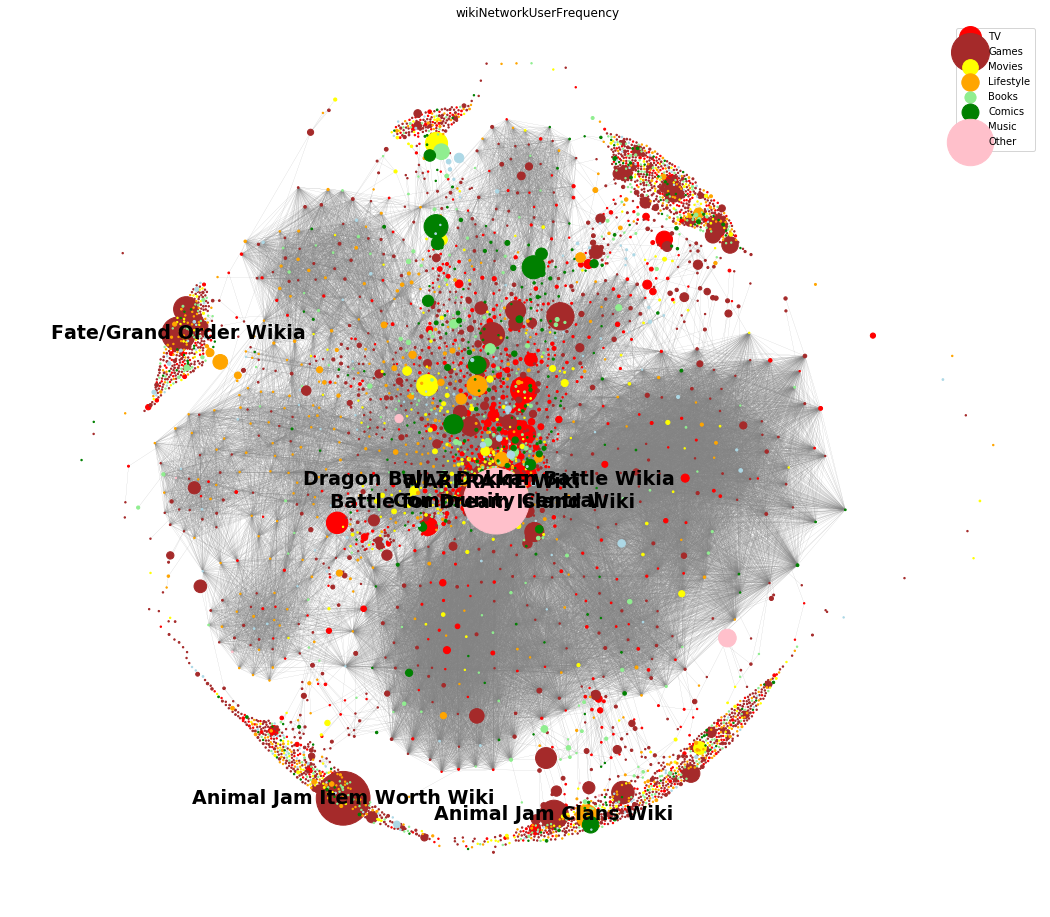

In [19]:
node_size = createNodeSizes(nodeSizeFrequency, hubs) 
for k,v in node_size.items():
    print(k, max(v), min(v), np.average(v))

drawAndSaveGraph(18, 16, G, positions, hubs, node_size, 760, 'wikiNetworkUserFrequency')

TV 645 0 91.51309408341416
Games 675 0 70.5813953488372
Movies 975 0 82.75324675324676
Lifestyle 315 0 64.65753424657534
Books 1020 0 72.34883720930233
Comics 585 0 94.5
Music 540 0 72.265625
Other 135 30 73.5


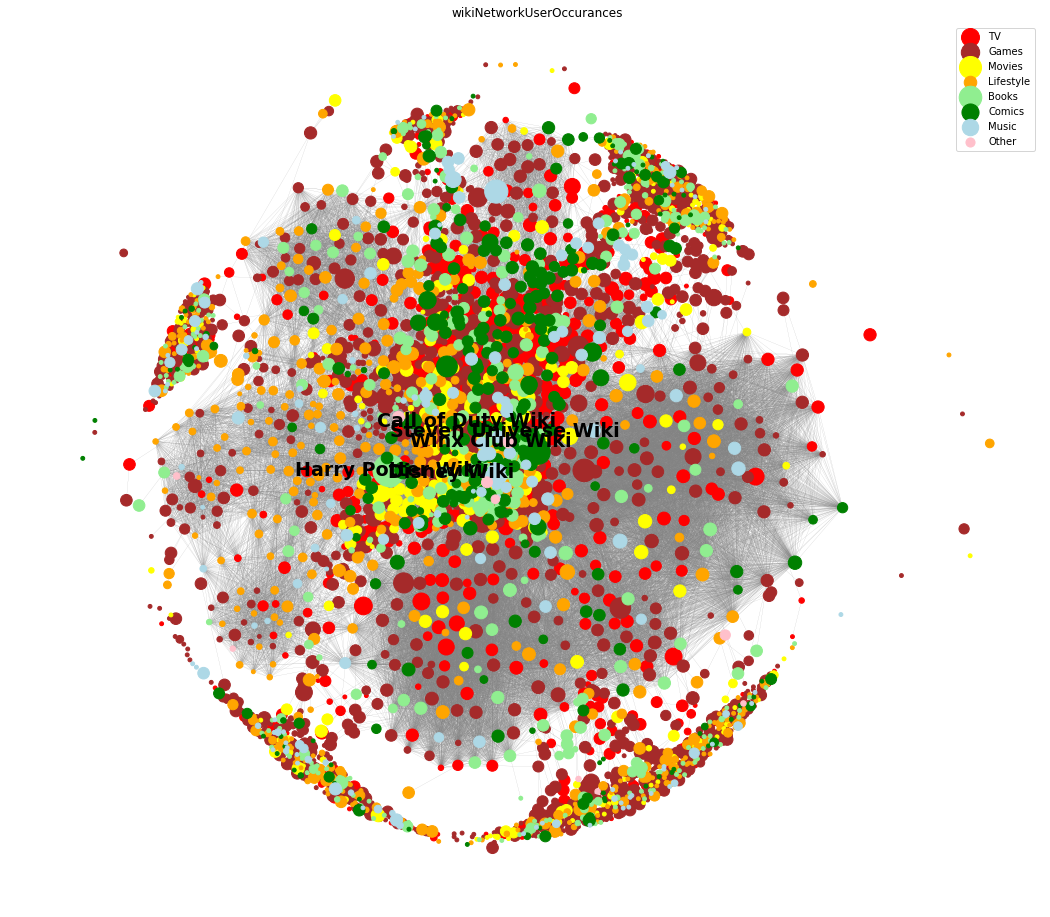

In [20]:
node_size = createNodeSizes(nodeSizeOccurances, hubs) 
for k,v in node_size.items():
    print(k, max(v), min(v), np.average(v))

drawAndSaveGraph(18, 16, G, positions, hubs, node_size, 600, 'wikiNetworkUserOccurances')

TV 283 0 21.680892337536374
Games 269 0 14.801641586867305
Movies 225 0 19.296103896103897
Lifestyle 266 0 24.226788432267885
Books 217 0 17.141860465116277
Comics 252 0 24.270588235294117
Music 272 0 21.484375
Other 67 0 26.7


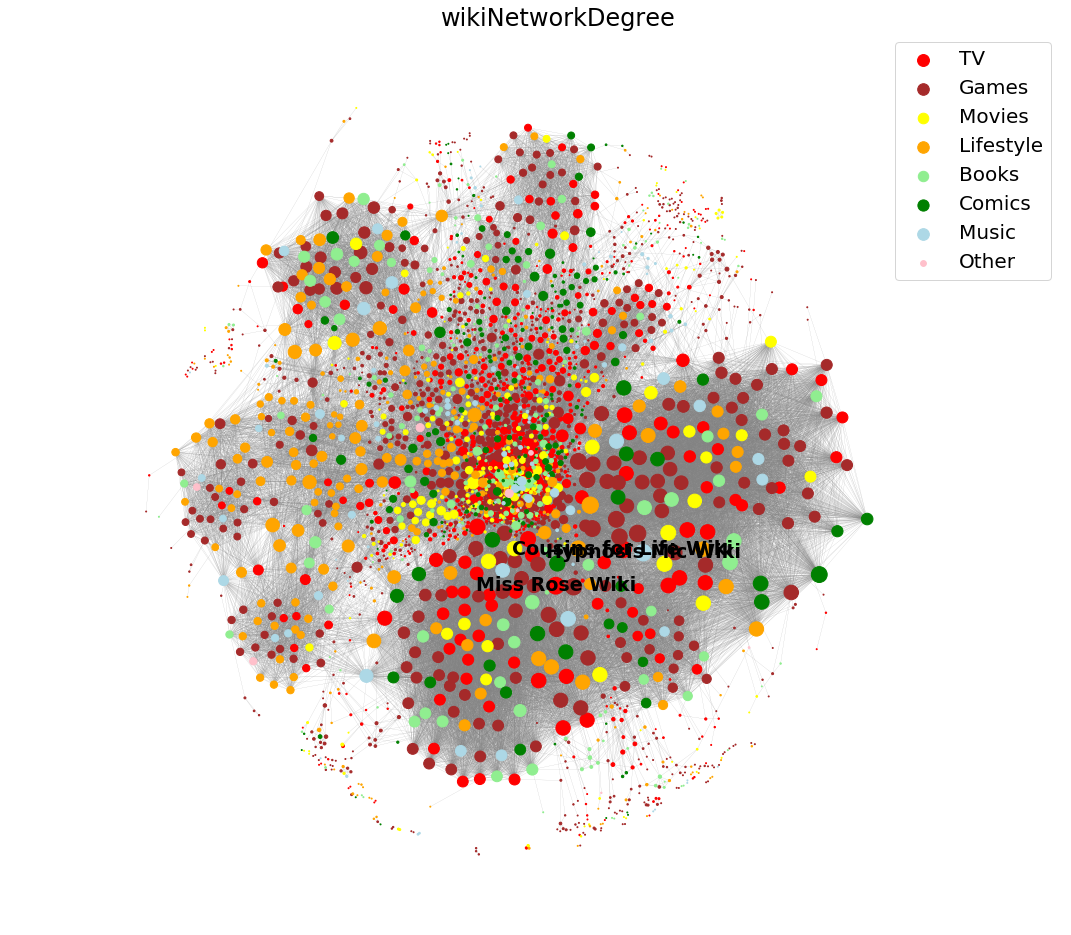

In [33]:
node_size = createNodeSizes(nodeSizeDegree, hubs) 
for k,v in node_size.items():
    print(k, max(v), min(v), np.average(v))

drawAndSaveGraph(18, 16, G, positions, hubs, node_size, 270, 'wikiNetworkDegree')

## 3 Tools, theory and analysis

Talk about how you've worked with text, including regular expressions, unicode, etc.
Describe which network science tools and data analysis strategies you've used, how those network science measures work, and why the tools you've chosen are right for the problem you're solving.
How did you use the tools to understand your dataset?


I envision Part 3: **Tools, theory and analysis** as the central part of the assignment, where you basically go through the steps in the analysis. So the structure of this part would be something like

* Explain the overall idea
* Analysis step 1
    * explain what you're interested in
    * explain the tool
    * apply the tool
    * discuss the outcome

### 3.1 Degree Distributions

In [22]:
def createHistigram(ylable, xlable, title, fileName, hubsDegree, bins):
    # Create Bin Histogram 
    plt.figure(figsize=(12, 3))  
    plt.style.use('seaborn-deep')
    
    maxDegree = 0
    for v in hubsDegree.values():
        if max(v)>maxDegree:
            maxDegree = max(v)
    bins = np.linspace(0, maxDegree, bins)

    plt.hist(list(hubsDegree.values()), 
         bins, 
         label=list(hubsDegree.keys()), 
         histtype='bar',
         edgecolor='black')
    
    plt.rcParams.update({'font.size': 20})
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.title(title)
    plt.ylabel(ylable)
    plt.xlabel(xlable)
    plt.savefig('graphs/'+fileName+'.png')
    plt.show()

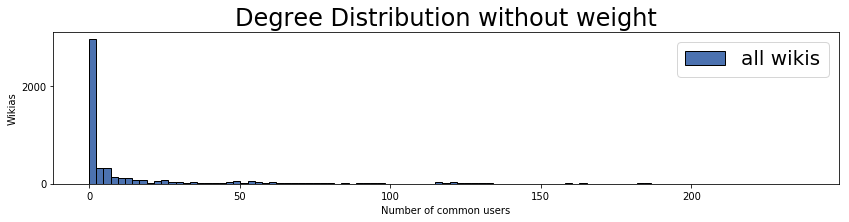

In [23]:
# Data
degrees = {}
degrees['all wikis'] = [val for (node, val) in G.degree()]

createHistigram("Wikias", 
                "Number of common users", 
                "Degree Distribution without weight", 
                "wikiDegreeSumHist", 
                degrees,
                100)

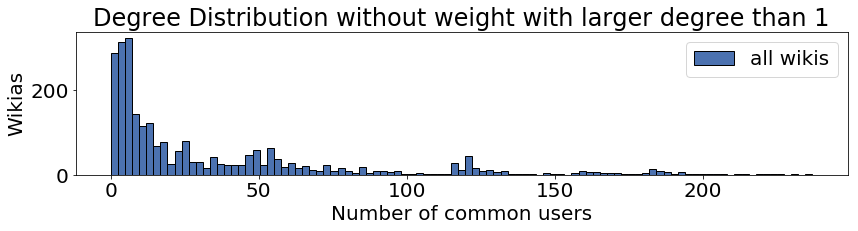

In [24]:
# Data
degrees = {}
degrees['all wikis'] = [val for (node, val) in G.degree() if val>1]

createHistigram("Wikias", 
                "Number of common users", 
                "Degree Distribution without weight with larger degree than 1", 
                "wikiDegreelarger1SumHist", 
                degrees,
                100)

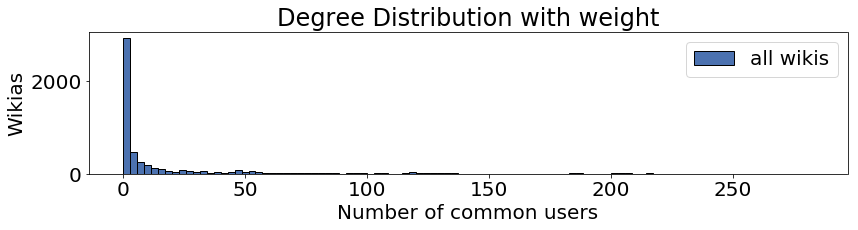

In [25]:
# Data
degrees = {}
degrees['all wikis'] = [val for (node, val) in G.degree(weight='weight')]

createHistigram("Wikias", 
                "Number of common users", 
                "Degree Distribution with weight", 
                "wikiDegreeSumWeightHist", 
                degrees,
                100)

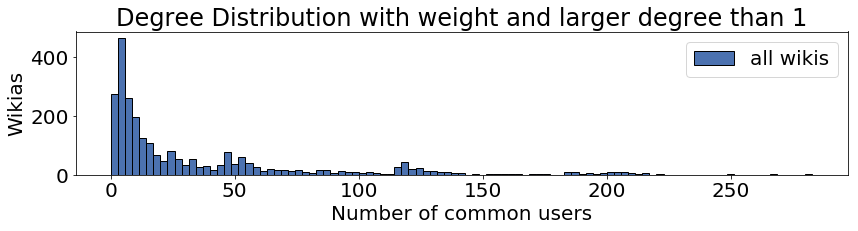

In [26]:
# Data
degrees = {}
degrees['all wikis'] = [val for (node, val) in G.degree(weight='weight') if val>1]

createHistigram("Wikias", 
                "Number of common users", 
                "Degree Distribution with weight and larger degree than 1", 
                "wikiDegreeSumlarger1WeightHist", 
                degrees,
                100)

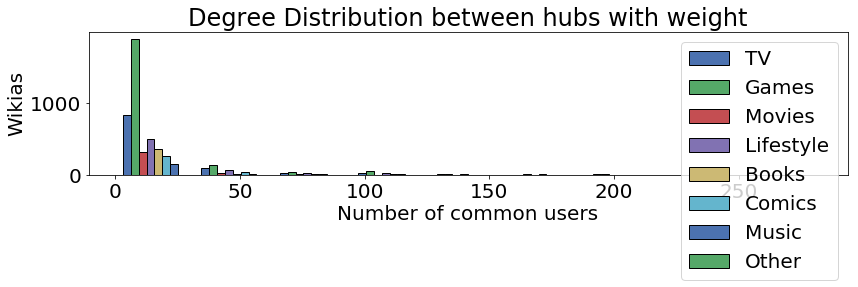

In [27]:
hubsDegree = createNodeSizes(nodeSizeDegree, hubs)
createHistigram("Wikias", 
                "Number of common users", 
                "Degree Distribution between hubs with weight", 
                "wikiDegreeWeightHist", 
                hubsDegree, 
                10)

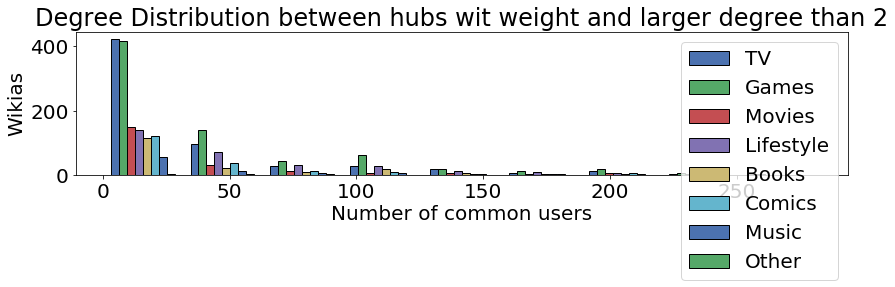

In [28]:
hubsDegreefilter = {}
for k,v in hubsDegree.items():
    hubsDegreefilter[k] = list(filter(lambda a: a > 2, v))

createHistigram("Wikias", 
                "Number of common users", 
                "Degree Distribution between hubs wit weight and larger degree than 2", 
                "wikiDegreelarger2WeightHist", 
                hubsDegreefilter, 
                10)

In [29]:
def createCumulativeHistigram(ylable, xlable, title, fileName, hubsDegree):
    
    # Create Cumulative Step Histogram 
    plt.figure(figsize=(12, 3))  
    plt.style.use('seaborn-deep')
    
    maxDegree = 0
    for v in hubsDegree.values():
        if max(v)>maxDegree:
            maxDegree = max(v)
    bins = np.linspace(0, maxDegree, 30)

    plt.hist(list(hubsDegree.values()), 
         bins, 
         label=list(hubsDegree.keys()), 
         histtype='step', 
         cumulative=True)
    #patch.linewidth

    plt.rcParams.update({'font.size': 20})
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.title(title)
    plt.ylabel(ylable)
    plt.xlabel(xlable)
    plt.savefig('graphs/'+fileName+'.png')
    plt.show()

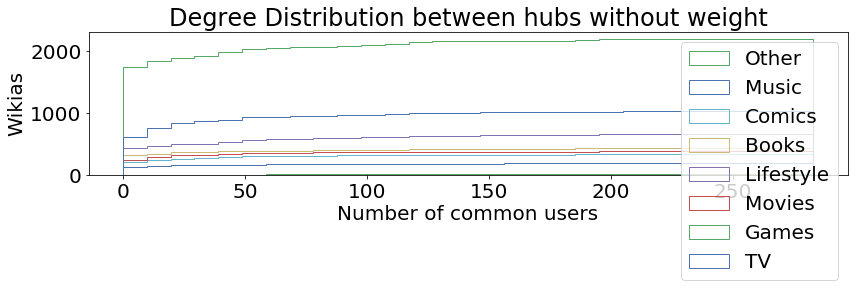

In [30]:
createCumulativeHistigram("Wikias", 
                          "Number of common users", 
                          "Degree Distribution between hubs without weight", 
                          "wikiDegreeCumulativeHist", 
                          hubsDegree)

**Log-Log Degree Distribution**

### 3.2 Compare to random Graph

### 3.3 Shortest Path Length

### 3.4 Centralities

### 3.5 Communities + matrix

### 3.6 TF-IDF

### 3.7 Sentiment

### 3.8 WordClouds

## 4 Discussion

* What went well?,
* What is still missing? What could be improved?, Why?